# Online Retail - Customer segmentation using RFM analysis

Today, we have a UK based Online Retailer, who is facing decline in sales and customer engagement. While their UI/UX team is working on revamping the website to enhance the user experience, the marketing team had approached us, data scientists (the unicorns who can make 2 + 2 = 8 possible, JK!), to help them manage their promotions and tailor them as close as possible to the customer behavior.

Well, this is a problem which can be solved using RFM analysis for segmenting the customers. Let's understand more about RFM analysis.

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement. RFM factors illustrate these facts:
* the more recent the purchase, the more responsive the customer is to promotions
* the more frequently the customer buys, the more engaged and satisfied they are
* monetary value differentiates heavy spenders from low-value purchasers

Well, instead of taking the classic approach of segmenting customers based on quantiles, today we will take a new route of identifying the number of segments using unsupervised learning techniques (clustering). Once we have identified the number of segments and reviewed the characteristics of these segements based on RFM values, we can define them and hence devise marketing campaigns around them accordingly.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# dataframe display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# style setting
sns.set_style('darkgrid')
plt.style.use('ggplot')

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

C:\DataScience\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Reading and understanding data

**Variable information:**

| **Variable** | **Description** |
|:--- | --- |
|**InvoiceNo** | A unique identifier assigned to each purchase transaction|
|**StockCode** | A unique identifier to track units of products in inventory and products sold|
|**Description** | Description of item purchased|
|**Quantity** | Purchase quantity of the item purchased|
|**InvoiceDate** | Date and time of invoice generated for the purchase|
|**UnitPrice** | Unit price of the purchase item|
|**CustomerID** | A unique identifier assigned to each customer|
|**Country** | Country where the purchase was made online|

In [2]:
# reading dataset
df_retail = pd.read_csv('OnlineRetail.csv', encoding = 'ISO-8859-1')

# displaying the dataframe head
df_retail.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
66658,541810,DOT,DOTCOM POSTAGE,1,21-01-2011 15:00,157.08,NaN,United Kingdom
390127,570499,84997D,CHILDRENS CUTLERY POLKADOT PINK,4,11-10-2011 09:19,4.15,12772.0,Portugal
301712,563351,23012,GLASS APOTHECARY BOTTLE PERFUME,11,15-08-2011 14:17,3.95,16902.0,United Kingdom
208699,555147,22697,GREEN REGENCY TEACUP AND SAUCER,6,31-05-2011 15:41,2.95,13505.0,Switzerland
458112,575757,22550,HOLIDAY FUN LUDO,2,11-11-2011 10:49,3.75,17295.0,United Kingdom


In [3]:
# dataframe dimensions
print(f"This dataframe has {df_retail.shape[0]} rows and {df_retail.shape[1]} columns.")

This dataframe has 541909 rows and 8 columns.


In [4]:
# columns info
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Observations:**
- `Quantity`, `UnitPrice` and `CustomerID` are numeric types.
- `InvoiceDate` is categorical type, we might need to extract the date part or cast it into DateTime type for our analysis.

In [5]:
# casting customer id into categorical
df_retail['CustomerID'] = df_retail['CustomerID'].astype('object')

# casting invoice date into date time
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'], format="%d-%m-%Y %H:%M")

# Data quality

### Missing values

In [6]:
# missing values
# percentage of rows with missing values
print(f"Percentage of rows with missing values : {round((sum(df_retail.isna().sum(axis=1) != 0) / df_retail.shape[0]) * 100, 2)}%")

# percentage of missing values in each variable
pd.DataFrame(zip(df_retail.columns,
                 df_retail.isna().any(),
                (df_retail.isna().sum() / df_retail.shape[0]) * 100),
             columns=['Column', 'Has Missing Values?', '% Missing Values'])\
    .sort_values('% Missing Values', ascending=False)\
    .style.background_gradient(cmap='coolwarm', low=0.2, high=0.2)

Percentage of rows with missing values : 24.93%


,Column,Has Missing Values?,% Missing Values
6,CustomerID,True,24.926694
2,Description,True,0.268311
0,InvoiceNo,False,0.000000
1,StockCode,False,0.000000
3,Quantity,False,0.000000
4,InvoiceDate,False,0.000000
5,UnitPrice,False,0.000000
7,Country,False,0.000000


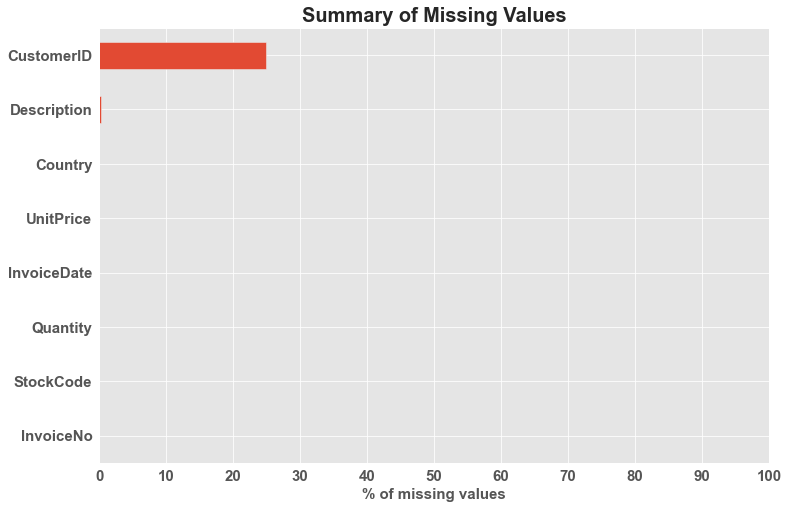

In [7]:
# visual summary of % of missing values in each column
(df_retail.isna().sum() / df_retail.shape[0] * 100)\
    .sort_values()\
    .plot(kind='barh', figsize=(12,8))
plt.xticks(np.arange(0,110,10), fontsize=15, fontweight='bold')
plt.xlabel("% of missing values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Summary of Missing Values", fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* There are missing values in `CustomerID` and `Description` variables.
* Almost 25% of the rows have missing `CustomerID` value. These could be purchases made online through guest account and not through a registered customer account.
* Imputing these missing values using sampling method or with one single new ID value would impact our analysis results. Since our analysis is around customers and `CustomerID` is the core variable here, and there is no sensible way to impute these values, we will have to drop the missing value rows.
* `Description` has less than 1% missing values, we can safely ignore these as well.

# Data summary

In [8]:
# 5-point statistical summary on numerical variables
df_retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


**Observations:**
* Avg. purchase `Quantity` is around 9 (but the average might be polluted due to huge outliers that we see). Median purchase `Quantity` is 3, which looks reasonable. There are some unusually huge purchase quantities, these could be outliers.
* Avg. `UnitPrice` of the pruchase items is 4.6 units (but the average might be polluted due to huge outliers that we see). Median `UnitPrice` is 2.08 units. We see some unusually inflated unit price values, looks like some expensive items or maybe incorrect data.
* Also, there are few negative values in `Quantity` and `UnitPrice`. Could they mean returns/cancel orders? Or data quality issues?
* We might have to do some data cleaning.

In [9]:
# statistical summary on categorical variables
df_retail.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
CustomerID,406829.0,4372.0,17841.0,7983.0
Country,541909,38,United Kingdom,495478


**Observations:**
* 4,372 unique registered customers.
* 26k (approx) unique invoices.
* Purchased made across 38 different countries.

In [10]:
# statistical summary on datetime variables
df_retail.describe(include='datetime').T

,count,unique,top,freq,first,last
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00


**Observations:**
* This is purchase history of purchases made between December 2010 and December 2011.

# Data cleaning

### Missing values

In [11]:
# dropping null value rows
df_retail = df_retail.dropna()

In [12]:
# sanity check
print(f"Percentage of rows with missing values (after dropping missing value rows) : {round((sum(df_retail.isna().sum(axis=1) != 0) / df_retail.shape[0]) * 100, 2)}%")

Percentage of rows with missing values (after dropping missing value rows) : 0.0%


In [13]:
# removing decimals from customer id values
df_retail['CustomerID'] = df_retail['CustomerID'].astype('int').astype('object')

# EDA

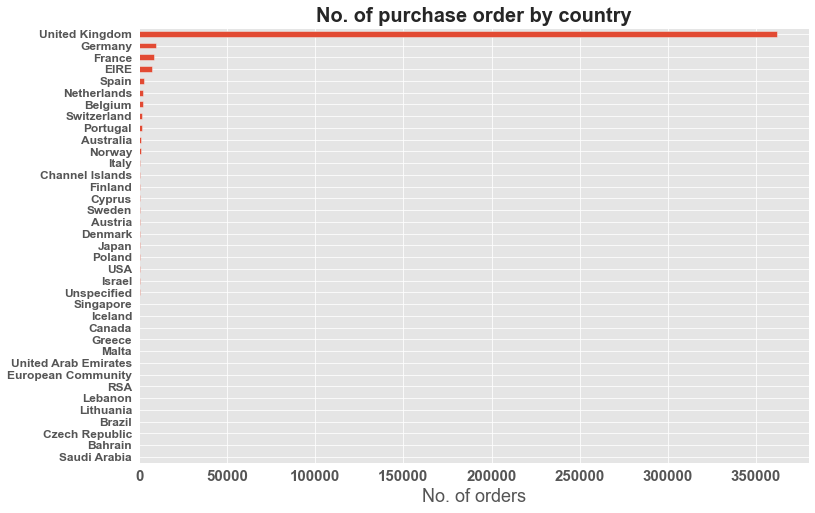

In [14]:
# purchase orders by country
plt.figure(figsize=(12,8))
df_retail['Country'].value_counts(ascending=True)\
                    .plot(kind='barh')
plt.xlabel('No. of orders', fontsize=18)
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of purchase order by country', fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* Majority of the orders (more than 90%) are from `United Kingdom`. This retailer is popular in UK.

In [15]:
# creating time series of orders
orders_time_series = df_retail[['InvoiceDate','InvoiceNo']].drop_duplicates()
orders_time_series.set_index('InvoiceDate', inplace=True)

# sample rows
orders_time_series.sample(5)

,InvoiceNo
InvoiceDate,
2011-11-22 14:59:00,578054
2011-08-26 14:13:00,564649
2011-05-10 10:29:00,552544
2011-10-14 15:26:00,571243
2011-04-19 12:26:00,550613


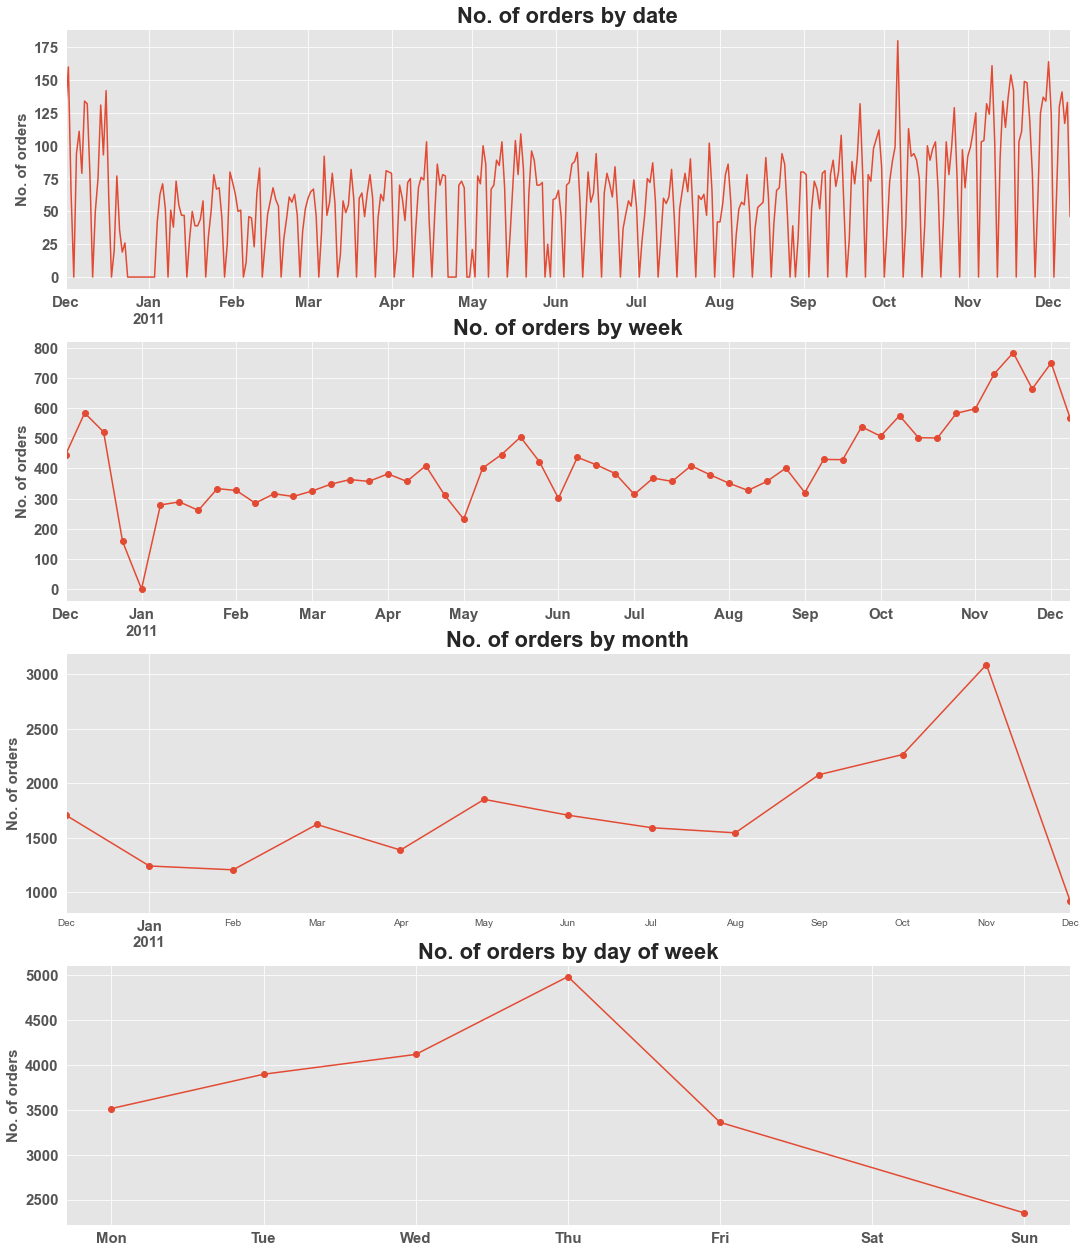

In [16]:
# time series analysis
plt.subplots(4, 1, figsize=(18,22))

# plot 1- no. of orders by date
plt.subplot(4, 1, 1)
orders_time_series.to_period('D').resample('D')['InvoiceNo'].count().plot()
plt.xlabel('')
plt.ylabel('No. of orders', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of orders by date', fontsize=22, fontweight='bold')

# plot 2- no. of orders by week
plt.subplot(4, 1, 2)
orders_time_series.to_period('W').resample('W')['InvoiceNo'].count().plot(marker='o')
plt.xlabel('')
plt.ylabel('No. of orders', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of orders by week', fontsize=22, fontweight='bold')

# plot 3- no. of orders by month
plt.subplot(4, 1, 3)
orders_time_series.to_period('M').resample('M')['InvoiceNo'].count().plot(marker='o')
plt.xlabel('')
plt.ylabel('No. of orders', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of orders by month', fontsize=22, fontweight='bold')

# plot 4- no. of orders by day of week
plt.subplot(4, 1, 4)
orders_time_series['WeekDay'] = orders_time_series.index.dayofweek
orders_time_series.groupby('WeekDay')['InvoiceNo'].count().plot(marker='o')
plt.xlabel('')
plt.ylabel('No. of orders', fontsize=15, fontweight='bold')
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of orders by day of week', fontsize=22, fontweight='bold')

# display plot
plt.show()

**Observation:**

* From the first graph, we can see that there is seasonality at weekly level, with peaks around mid-week. 
* From the second graph, we can see that the orders are lowest during first week of May, and peaks once during mid May and again during Nov and Dec. There are 0 orders during first week of Jan, could be due to data loss.
* The trend remains almost similar/constant throughout the year, lowest during starting of the year and gradually increases till Nov, and a sudden rise in orders towards the end of the year, probably because of holiday season.
* From the fourth graph, we can see that the orders peak on Thursday. This could probably due to the fact that shipping takes 2-3 days and then customers can recieve them during weekend when they are at home.
* Strangely, the data tells that there was no single order placed on Saturday. This explains the seasonal weekly valleys of 0 orders in the first graph. I can't think of any explaination to that other than a systematic data loss.

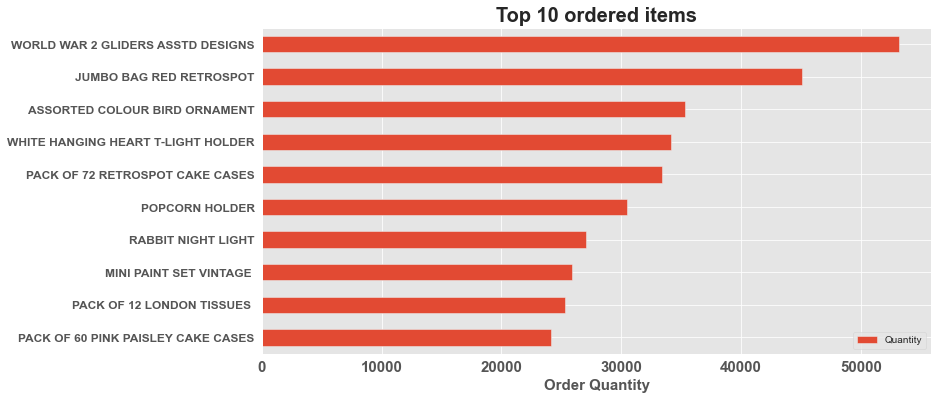

In [17]:
# top 10 purchased items
plt.figure(figsize=(12,6))
df_retail.groupby('Description')[['Quantity']].sum()\
            .sort_values('Quantity', ascending=False)\
            .head(10)\
            .sort_values('Quantity', ascending=True)\
            .plot(kind='barh', ax=plt.gca())
plt.xlabel('Order Quantity', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Top 10 ordered items', fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* Ornaments, Holders, Cake Cases, and Tissues!

# Customer analytics

In [18]:
# customer summary profile
# net total no. of orders by customer (including cancel orders)
df_customer_summary = df_retail[['CustomerID','InvoiceNo']]\
                        .drop_duplicates()\
                        .groupby('CustomerID')[['InvoiceNo']].count()\
                        .reset_index()\
                        .rename(columns={'InvoiceNo':'TotalOrders'})

# net order quantity
df_customer_summary['NetOrderQuantity'] = df_retail.groupby('CustomerID')[['Quantity']].sum().values

# total order quantity (excluding returns)
return_order_per_customer = df_retail[df_retail['Quantity'] >= 0]\
                            .groupby('CustomerID')[['Quantity']].sum()\
                            .reset_index().rename(columns={'Quantity':'TotalQuantityOrdered'})
df_customer_summary = pd.merge(df_customer_summary, return_order_per_customer, how='left', on='CustomerID')
df_customer_summary['TotalQuantityOrdered'].fillna(0, inplace=True)
df_customer_summary['TotalQuantityOrdered'] = df_customer_summary['TotalQuantityOrdered'].astype('int')

# total return order quantity
return_order_per_customer = df_retail[df_retail['Quantity'] < 0]\
                            .groupby('CustomerID')[['Quantity']].sum()\
                            .reset_index().rename(columns={'Quantity':'TotalQuantityReturned'})
df_customer_summary = pd.merge(df_customer_summary, return_order_per_customer, how='left', on='CustomerID')
df_customer_summary['TotalQuantityReturned'].fillna(0, inplace=True)
df_customer_summary['TotalQuantityReturned'] = df_customer_summary['TotalQuantityReturned'].astype('int') * -1

# order-return ratio
df_customer_summary['ReturnRatio'] = round(df_customer_summary['TotalQuantityReturned'] / df_customer_summary['TotalQuantityOrdered'], 2)

# total order amount
df_retail['OrderAmount'] = df_retail['Quantity'] * df_retail['UnitPrice']
df_customer_summary['TotalOrderAmount'] = df_retail.groupby('CustomerID')[['OrderAmount']].sum().values

# order amount per order
df_customer_summary['OrderAmountPerOrder'] = round(df_customer_summary['TotalOrderAmount'] / df_customer_summary['TotalOrders'], 2)

# sample rows
df_customer_summary.sample(5)

,CustomerID,TotalOrders,NetOrderQuantity,TotalQuantityOrdered,TotalQuantityReturned,ReturnRatio,TotalOrderAmount,OrderAmountPerOrder
1571,14473,2,88,88,0,0.00,234.34,117.17
333,12752,1,2262,2262,0,0.00,4366.78,4366.78
4181,18030,3,66,67,1,0.01,220.70,73.57
2176,15288,5,775,775,0,0.00,2306.52,461.30
3078,16506,2,42,42,0,0.00,90.30,45.15


In [19]:
# 5-point summary statistics
df_customer_summary.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CustomerID,4372.0,15299.68,1722.39,12346.00,13812.75,15300.50,16778.25,18287.00
TotalOrders,4372.0,5.08,9.34,1.00,1.00,3.00,5.00,248.00
NetOrderQuantity,4372.0,1122.34,4672.79,-303.00,153.00,365.00,962.25,196719.00
TotalQuantityOrdered,4372.0,1185.20,5037.54,0.00,157.00,374.50,983.00,197491.00
TotalQuantityReturned,4372.0,62.86,1683.60,0.00,0.00,0.00,4.00,80995.00
ReturnRatio,4372.0,inf,NaN,0.00,0.00,0.00,0.01,inf
TotalOrderAmount,4372.0,1898.46,8219.35,-4287.63,293.36,648.08,1611.72,279489.02
OrderAmountPerOrder,4372.0,315.88,361.24,-4287.63,151.99,236.98,370.82,6207.67


**Observations:**

* Total registered customers: 4372
* Clearly, there are outliers in this data, customers who are placing bulk orders. Could be a corporate customer or for business purpose. Keeping this in mind, let's focus on median statistic rather than mean statistic.
* In a year, on an average, a customer:
    * places 3-4 orders
    * orders 365 quantity
    * 700 currency units (approx) worth of orders
    * 240 currency units (approx) worth of order per order
* `ReturnRatio` at 50th percentile is 0, which is good. But, at 75th percentile, there are non-zero values. Meaning, at least 1/4 of the customers are returning orders.
* As we can see, there are negative values in `NetOrderQuantity` and inf values in `ReturnRatio`. Possible explaination is that only the returned orders were captured for that particular customer in the selected time span (snapshot of data). We can remove those customers for our analysis.

## Data cleaning

In [20]:
# dropping customers with only return orders
mask = (df_customer_summary['TotalQuantityOrdered'] == 0) & (df_customer_summary['TotalQuantityReturned'] > 0)
df_customer_summary = df_customer_summary[-mask]

In [21]:
# dropping customers with negative net order quantity
mask = (df_customer_summary['NetOrderQuantity'] < 0) | (df_customer_summary['TotalOrderAmount'] < 0)
df_customer_summary = df_customer_summary[-mask]

## Outliers

|****************************** Data Distribution - TotalQuantityOrdered ******************************|
Summary statistics:
 count      4328.00
mean       1196.76
std        5061.75
min           1.00
25%         161.00
50%         380.00
75%         993.25
max      197491.00
Name: TotalQuantityOrdered, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  20.35
Number of outliers found: 225


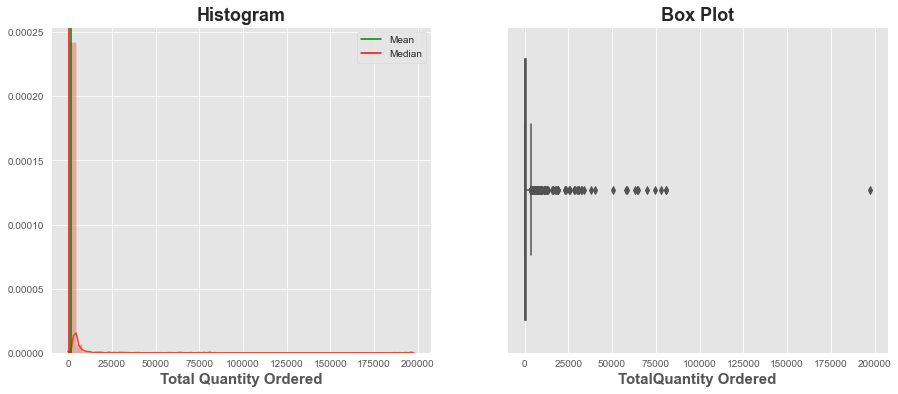

In [22]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - TotalQuantityOrdered " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_customer_summary['TotalQuantityOrdered'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_customer_summary['TotalQuantityOrdered'].skew().round(2))

# number of outliers
Q1 = df_customer_summary['TotalQuantityOrdered'].quantile(0.25)
Q3 = df_customer_summary['TotalQuantityOrdered'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_customer_summary['TotalQuantityOrdered'] < Q1 - 3*IQR) | (df_customer_summary['TotalQuantityOrdered'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_customer_summary['TotalQuantityOrdered'])
plt.axvline(df_customer_summary['TotalQuantityOrdered'].mean(), color='g', label="Mean")
plt.axvline(df_customer_summary['TotalQuantityOrdered'].median(), color='r', label="Median")
plt.legend()
plt.title("Histogram", fontsize=18, fontweight='bold')
plt.xlabel("Total Quantity Ordered", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_customer_summary['TotalQuantityOrdered'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("TotalQuantity Ordered", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* We can see that the variable is highly skewed and there is a heavy right tail.
* Let's drop the 225 outliers that were found.

In [23]:
# dropping outliers in TotalQuantityOrdered
mask = (df_customer_summary['TotalQuantityOrdered'] < Q1 - 3*IQR) | (df_customer_summary['TotalQuantityOrdered'] > Q3 + 3*IQR)
df_customer_summary = df_customer_summary[-mask]

|****************************** Data Distribution - TotalQuantityOrdered ******************************|
Summary statistics:
 count    4103.00
mean      623.47
std       682.13
min         1.00
25%       153.00
50%       349.00
75%       841.00
max      3466.00
Name: TotalQuantityOrdered, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  1.76
Number of outliers found: 63


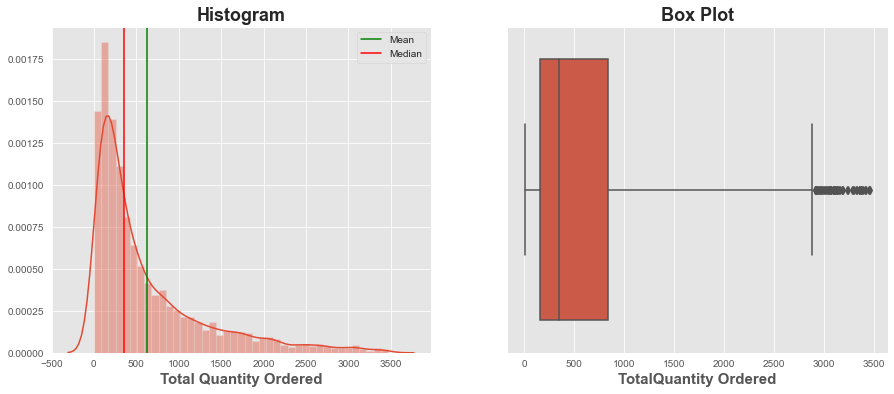

In [24]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - TotalQuantityOrdered " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_customer_summary['TotalQuantityOrdered'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_customer_summary['TotalQuantityOrdered'].skew().round(2))

# number of outliers
Q1 = df_customer_summary['TotalQuantityOrdered'].quantile(0.25)
Q3 = df_customer_summary['TotalQuantityOrdered'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_customer_summary['TotalQuantityOrdered'] < Q1 - 3*IQR) | (df_customer_summary['TotalQuantityOrdered'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_customer_summary['TotalQuantityOrdered'])
plt.axvline(df_customer_summary['TotalQuantityOrdered'].mean(), color='g', label="Mean")
plt.axvline(df_customer_summary['TotalQuantityOrdered'].median(), color='r', label="Median")
plt.legend()
plt.title("Histogram", fontsize=18, fontweight='bold')
plt.xlabel("Total Quantity Ordered", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_customer_summary['TotalQuantityOrdered'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("TotalQuantity Ordered", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* The data distribution and data profile of the variable looks good after removing the outliers.

In [25]:
# sanity check - 5-point summary
df_customer_summary.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4103.0,15318.46,1715.71,12347.0,13843.00,15326.00,16798.00,18287.00
TotalOrders,4103.0,3.95,4.37,1.0,1.00,2.00,5.00,86.00
NetOrderQuantity,4103.0,613.41,672.90,0.0,150.00,343.00,826.50,3459.00
TotalQuantityOrdered,4103.0,623.47,682.13,1.0,153.00,349.00,841.00,3466.00
TotalQuantityReturned,4103.0,10.06,57.39,0.0,0.00,0.00,2.00,1515.00
ReturnRatio,4103.0,0.02,0.07,0.0,0.00,0.00,0.00,1.00
TotalOrderAmount,4103.0,1071.19,1219.17,0.0,289.36,613.95,1386.42,10510.00
OrderAmountPerOrder,4103.0,297.15,282.67,0.0,151.52,231.28,356.30,6207.67


**Observations:**

* Now the data looks much more cleaner. Think we are good to continue with our analysis.

In [26]:
# total customers after cleaning data
print(f"Total number of customers left for modelling after cleaning the data: {df_customer_summary.shape[0]}")

Total number of customers left for modelling after cleaning the data: 4103


## Time to answer some interesting questions

**Who are the top 10 customers that are frequently placing orders?**
<br>**Who are top 10 customers that bring in revenue?**
<br>**Who are the top 10 customers that have highest order amount per order?**
<br>**Who are top 10 customers with highest return ratio?**

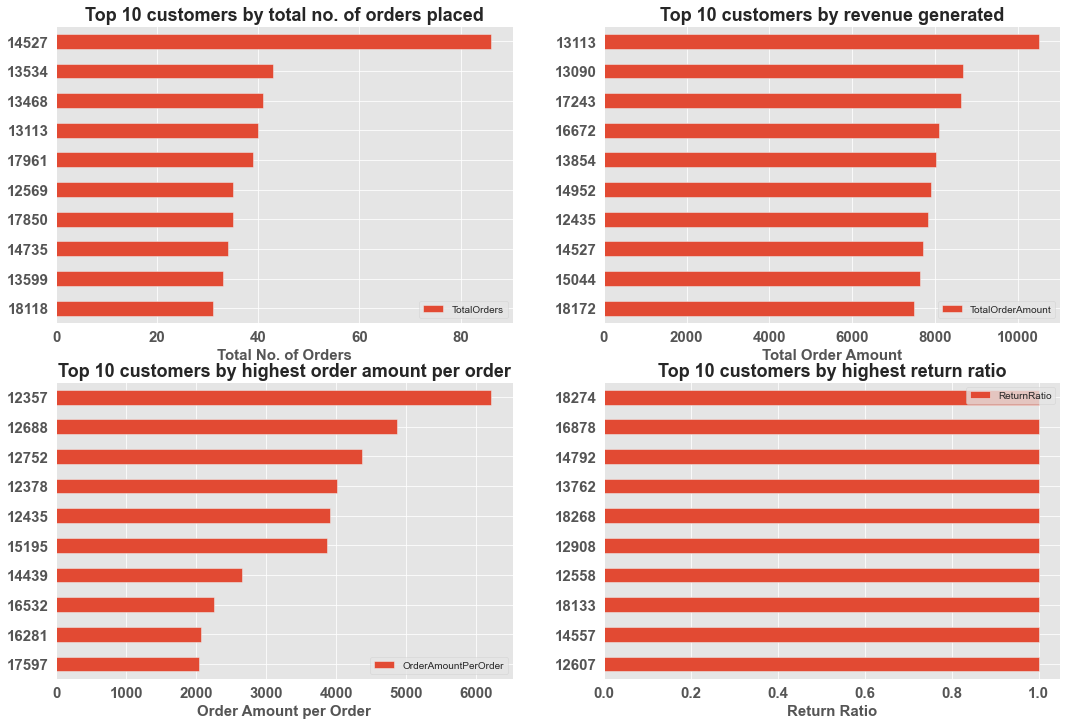

In [27]:
# subplots
plt.subplots(2,2, figsize=(18,12))

# plot 1 - top 10 customers by total no. of orders placed
plt.subplot(2,2,1)
df_customer_summary.sort_values('TotalOrders', ascending=False)\
    [['CustomerID','TotalOrders']]\
    .head(10)\
    .sort_values('TotalOrders', ascending=True)\
    .plot(kind='barh', y='TotalOrders', x='CustomerID', ax=plt.gca())
plt.xlabel('Total No. of Orders', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Top 10 customers by total no. of orders placed', fontsize=18, fontweight='bold')

# plot 2 - top 10 customers by revenue generated
plt.subplot(2,2,2)
df_customer_summary.sort_values('TotalOrderAmount', ascending=False)\
    [['CustomerID','TotalOrderAmount']]\
    .head(10)\
    .sort_values('TotalOrderAmount', ascending=True)\
    .plot(kind='barh', y='TotalOrderAmount', x='CustomerID', ax=plt.gca())
plt.xlabel('Total Order Amount', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Top 10 customers by revenue generated', fontsize=18, fontweight='bold')

# plot 3 - top 10 customers by highest order amount per order
plt.subplot(2,2,3)
df_customer_summary.sort_values('OrderAmountPerOrder', ascending=False)\
    [['CustomerID','OrderAmountPerOrder']]\
    .head(10)\
    .sort_values('OrderAmountPerOrder', ascending=True)\
    .plot(kind='barh', y='OrderAmountPerOrder', x='CustomerID', ax=plt.gca())
plt.xlabel('Order Amount per Order', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Top 10 customers by highest order amount per order', fontsize=18, fontweight='bold')

# plot 4 - top 10 customers by highest return ratio
plt.subplot(2,2,4)
df_customer_summary.sort_values('ReturnRatio', ascending=False)\
    [['CustomerID','ReturnRatio']]\
    .head(10)\
    .sort_values('ReturnRatio', ascending=True)\
    .plot(kind='barh', y='ReturnRatio', x='CustomerID', ax=plt.gca())
plt.xlabel('Return Ratio', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Top 10 customers by highest return ratio', fontsize=18, fontweight='bold')

# display plots
plt.show()

# Customer segmentation

## Preparing data

In [28]:
# monetary and frequency
df_rfm = df_customer_summary[['CustomerID','TotalOrders','TotalOrderAmount']]

# creating dataframe to calculate customer wise recency value
df_recency = df_retail[['CustomerID','InvoiceDate']]

# calculating the max value of invoice date
max_invoice_date = max(df_recency['InvoiceDate'])

# offsetting the max date by one day
max_invoice_date = max_invoice_date + pd.DateOffset(days=1)

# calcualting the date difference from max invoice date
df_recency['DateDiff'] = max_invoice_date - df_recency['InvoiceDate']

# calculating recency value of each customer
df_rfm = df_rfm.merge(df_recency.groupby('CustomerID')[['DateDiff']].min().reset_index(), on='CustomerID', how='inner')

# trimming off the time value from Recency
df_rfm['DateDiff'] = df_rfm['DateDiff'].dt.days

# renaming columns
df_rfm.rename(columns={'TotalOrders':'Frequency', 
                       'TotalOrderAmount':'Monetary',
                       'DateDiff':'Recency'}, inplace=True)

# sample rows
df_rfm.sample(5)

,CustomerID,Frequency,Monetary,Recency
1278,14218,1,169.48,43
90,12464,8,1212.05,10
1412,14415,18,5811.56,1
2011,15267,5,1717.36,22
3689,17690,16,4748.45,30


In [29]:
# 5-point summary statistics
df_rfm.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4103.0,15318.46,1715.71,12347.0,13843.00,15326.00,16798.00,18287.0
Frequency,4103.0,3.95,4.37,1.0,1.00,2.00,5.00,86.0
Monetary,4103.0,1071.19,1219.17,0.0,289.36,613.95,1386.42,10510.0
Recency,4103.0,93.98,99.91,1.0,18.00,52.00,148.00,374.0


**Observations:**

* The summary statistics look ok.
* Let's check for the data distribution and data profile of the three variables in case we need to apply any log transformations to any of the variables.

|****************************** Data Distribution - Frequency ******************************|
Summary statistics:
 count    4103.00
mean        3.95
std         4.37
min         1.00
25%         1.00
50%         2.00
75%         5.00
max        86.00
Name: Frequency, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  4.22
Number of outliers found: 72


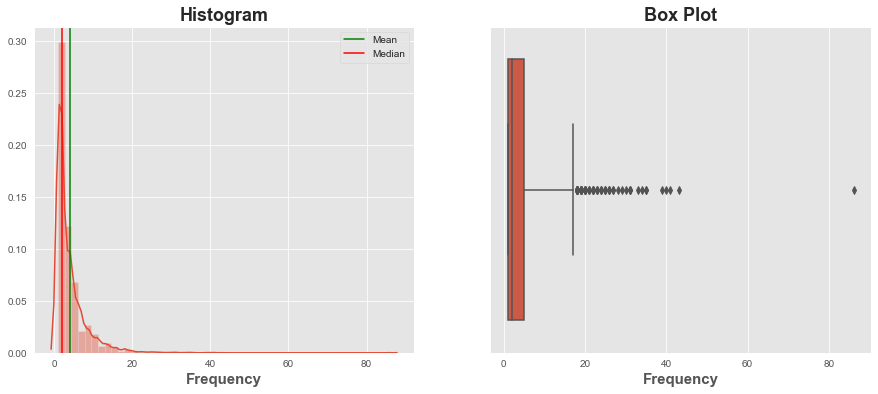

In [30]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - Frequency " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_rfm['Frequency'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_rfm['Frequency'].skew().round(2))

# number of outliers
Q1 = df_rfm['Frequency'].quantile(0.25)
Q3 = df_rfm['Frequency'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_rfm['Frequency'] < Q1 - 3*IQR) | (df_rfm['Frequency'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_rfm['Frequency'])
plt.axvline(df_rfm['Frequency'].mean(), color='g', label="Mean")
plt.axvline(df_rfm['Frequency'].median(), color='r', label="Median")
plt.legend()
plt.title("Histogram", fontsize=18, fontweight='bold')
plt.xlabel("Frequency", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_rfm['Frequency'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("Frequency", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* From the box plot we can see that there's one extreme value, 86. Let's remove the extreme value (outlier) and apply log transformation on the remaining values to remove skewness.

In [31]:
# removing outliers
mask = df_rfm['Frequency'] > 60
df_rfm = df_rfm[-mask]

# applying log transformation
df_rfm['ln_Frequency'] = np.log(df_rfm['Frequency'])

|****************************** Data Distribution - ln_Frequency ******************************|
Summary statistics:
 count    4102.00
mean        0.98
std         0.85
min         0.00
25%         0.00
50%         0.69
75%         1.61
max         3.76
Name: ln_Frequency, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  0.46
Number of outliers found: 0


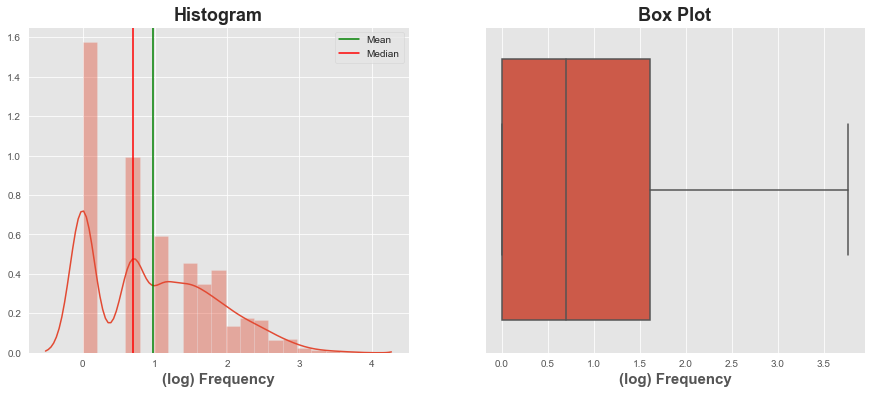

In [32]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - ln_Frequency " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_rfm['ln_Frequency'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_rfm['ln_Frequency'].skew().round(2))

# number of outliers
Q1 = df_rfm['ln_Frequency'].quantile(0.25)
Q3 = df_rfm['ln_Frequency'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_rfm['ln_Frequency'] < Q1 - 3*IQR) | (df_rfm['ln_Frequency'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_rfm['ln_Frequency'])
plt.axvline(df_rfm['ln_Frequency'].mean(), color='g', label="Mean")
plt.axvline(df_rfm['ln_Frequency'].median(), color='r', label="Median")
plt.legend()
plt.title("Histogram", fontsize=18, fontweight='bold')
plt.xlabel("(log) Frequency", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_rfm['ln_Frequency'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("(log) Frequency", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* Looks good now, no significant skewness, no outliers.

|****************************** Data Distribution - Monetary ******************************|
Summary statistics:
 count     4102.00
mean      1069.57
std       1214.90
min          0.00
25%        289.35
50%        613.19
75%       1384.81
max      10510.00
Name: Monetary, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  2.29
Number of outliers found: 96


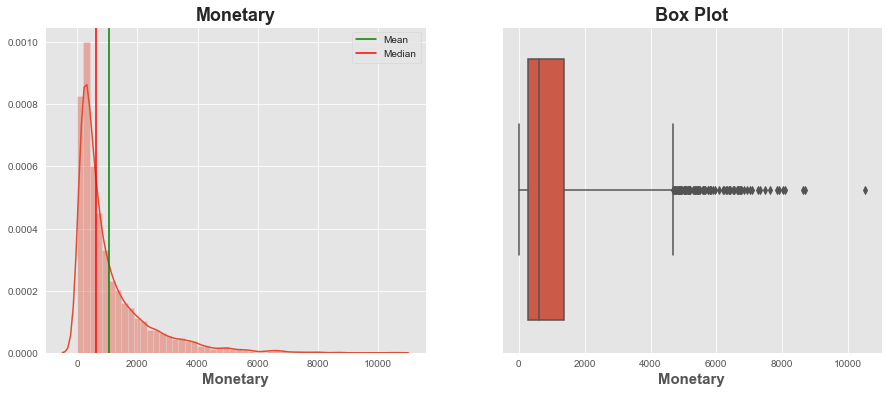

In [33]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - Monetary " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_rfm['Monetary'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_rfm['Monetary'].skew().round(2))

# number of outliers
Q1 = df_rfm['Monetary'].quantile(0.25)
Q3 = df_rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_rfm['Monetary'] < Q1 - 3*IQR) | (df_rfm['Monetary'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_rfm['Monetary'])
plt.axvline(df_rfm['Monetary'].mean(), color='g', label="Mean")
plt.axvline(df_rfm['Monetary'].median(), color='r', label="Median")
plt.legend()
plt.title("Monetary", fontsize=18, fontweight='bold')
plt.xlabel("Monetary", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_rfm['Monetary'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("Monetary", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* There is one extreme value, Monetary above 10,000 currency units.
* Also, there is heavy skewness in the distribution of values, let's apply log transaformation to remove skewness.

In [34]:
# removing outliers
mask = (df_rfm['Monetary'] > 10000) | (df_rfm['Monetary'] < 1)
df_rfm = df_rfm[-mask]

# applying log transformation
df_rfm['ln_Monetary'] = np.log1p(df_rfm['Monetary'])

|****************************** Data Distribution - ln_Monetary ******************************|
Summary statistics:
 count    4092.00
mean        6.43
std         1.08
min         1.56
25%         5.67
50%         6.42
75%         7.24
max         9.07
Name: ln_Monetary, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -0.08
Number of outliers found: 0


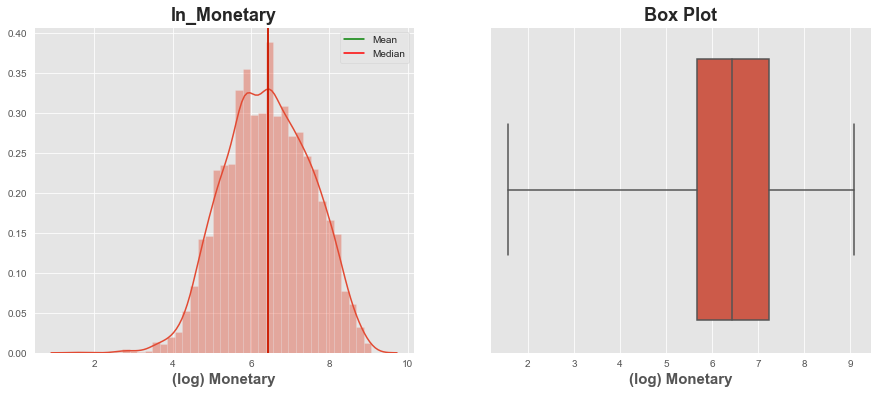

In [35]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - ln_Monetary " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_rfm['ln_Monetary'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_rfm['ln_Monetary'].skew().round(2))

# number of outliers
Q1 = df_rfm['ln_Monetary'].quantile(0.25)
Q3 = df_rfm['ln_Monetary'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_rfm['ln_Monetary'] < Q1 - 3*IQR) | (df_rfm['ln_Monetary'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_rfm['ln_Monetary'])
plt.axvline(df_rfm['ln_Monetary'].mean(), color='g', label="Mean")
plt.axvline(df_rfm['ln_Monetary'].median(), color='r', label="Median")
plt.legend()
plt.title("ln_Monetary", fontsize=18, fontweight='bold')
plt.xlabel("(log) Monetary", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_rfm['ln_Monetary'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("(log) Monetary", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* After removing outliers and applying log transaformation on the remaining values, data distribution looks good.

|****************************** Data Distribution - Recency ******************************|
Summary statistics:
 count    4092.00
mean       94.08
std        99.97
min         1.00
25%        18.00
50%        52.00
75%       148.25
max       374.00
Name: Recency, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  1.21
Number of outliers found: 0


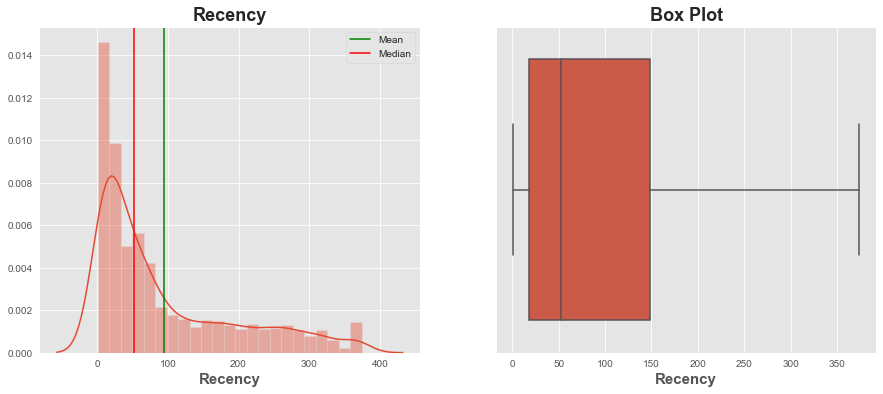

In [36]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - Recency " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_rfm['Recency'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_rfm['Recency'].skew().round(2))

# number of outliers
Q1 = df_rfm['Recency'].quantile(0.25)
Q3 = df_rfm['Recency'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_rfm['Recency'] < Q1 - 3*IQR) | (df_rfm['Recency'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_rfm['Recency'])
plt.axvline(df_rfm['Recency'].mean(), color='g', label="Mean")
plt.axvline(df_rfm['Recency'].median(), color='r', label="Median")
plt.legend()
plt.title("Recency", fontsize=18, fontweight='bold')
plt.xlabel("Recency", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_rfm['Recency'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("Recency", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* There are no outliers in `Recency`, sweet!
* There is little skewness in the data distribution. Let's apply log transformation and see.

In [37]:
# applying log transformation
df_rfm['ln_Recency'] = np.log(df_rfm['Recency'])

|****************************** Data Distribution - ln_Recency ******************************|
Summary statistics:
 count    4092.00
mean        3.81
std         1.41
min         0.00
25%         2.89
50%         3.95
75%         5.00
max         5.92
Name: ln_Recency, dtype: float64
----------------------------------------------------------------------------------------------------
Skew:  -0.55
Number of outliers found: 0


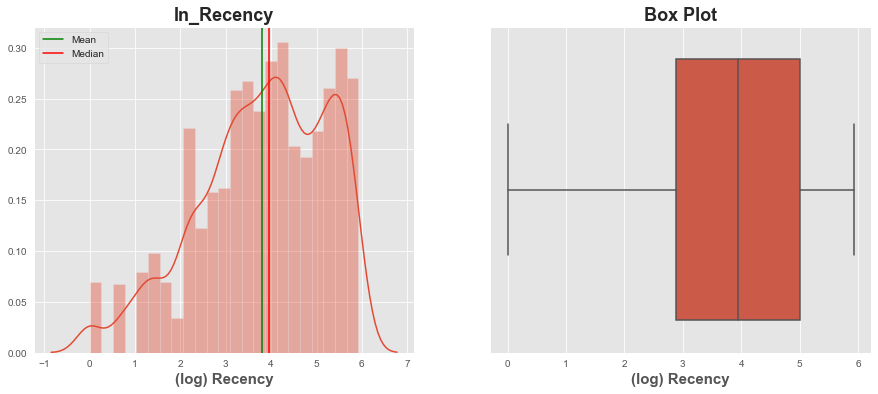

In [38]:
# variable data distirbution
print("|" + "*"*30 + " Data Distribution - ln_Recency " + "*"*30 + "|")

# summary statistics
print("Summary statistics:\n", df_rfm['ln_Recency'].describe().round(2))
print("-"*100)

# skewness
print("Skew: ", df_rfm['ln_Recency'].skew().round(2))

# number of outliers
Q1 = df_rfm['ln_Recency'].quantile(0.25)
Q3 = df_rfm['ln_Recency'].quantile(0.75)
IQR = Q3 - Q1
print("Number of outliers found:", ((df_rfm['ln_Recency'] < Q1 - 3*IQR) | (df_rfm['ln_Recency'] > Q3 + 3*IQR)).sum())

# shape of distribution
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(df_rfm['ln_Recency'])
plt.axvline(df_rfm['ln_Recency'].mean(), color='g', label="Mean")
plt.axvline(df_rfm['ln_Recency'].median(), color='r', label="Median")
plt.legend()
plt.title("ln_Recency", fontsize=18, fontweight='bold')
plt.xlabel("(log) Recency", fontsize=15, fontweight='bold')

# boxplot
plt.subplot(1,2,2)
sns.boxplot(df_rfm['ln_Recency'], whis=3)
plt.title("Box Plot", fontsize=18, fontweight='bold')
plt.xlabel("(log) Recency", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* After applying log transformation, skewness was reduced.

In [39]:
# total customers after cleaning data
print(f"Total number of customers left for modelling after cleaning the data: {df_rfm.shape[0]}")

Total number of customers left for modelling after cleaning the data: 4092


In [40]:
# subsetting variables for modelling
df_model = df_rfm[['ln_Recency','ln_Frequency','ln_Monetary']]

# scaling the numerical values
# initializing standard scaler
ss = StandardScaler()

# fitting the scaler with data and transforming the data
df_model_scaled = pd.DataFrame(ss.fit_transform(df_model),
                               columns=['ln_ss_Recency','ln_ss_Frequency','ln_ss_Monetary'])

## Clustering

In [41]:
# projecting the data into embeded space
tsne = TSNE(n_components=2)
Xt = tsne.fit_transform(df_model_scaled)

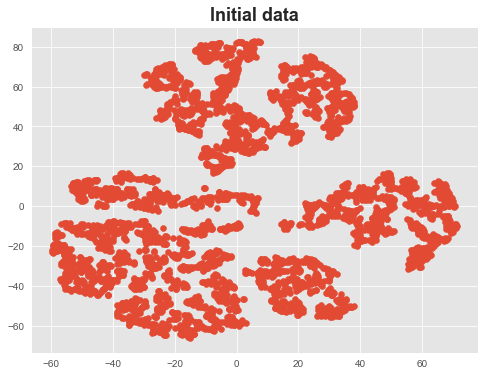

In [42]:
# initial data (clusters)
plt.figure(figsize=(8,6))
plt.scatter(Xt[:,0], Xt[:,1])
plt.title('Initial data', fontsize=18, fontweight='bold')
plt.show()

**Observations:**

* From the initial look at the data (projected into 2D space), we can identify 4-6 clusters. Let's see what model will give us.

In [43]:
# k-Means clustering with K between 2 and 20
list_sse = []
list_ss = []

# iterating over different values of K
for k in range(2,21):
    # setting K value
    model_kmeans = KMeans(n_clusters=k)
    model_kmeans.fit(df_model_scaled)
    # sse
    list_sse.append(model_kmeans.inertia_)
    # silhouette score
    list_ss.append(silhouette_score(df_model_scaled, model_kmeans.labels_, metric='euclidean'))

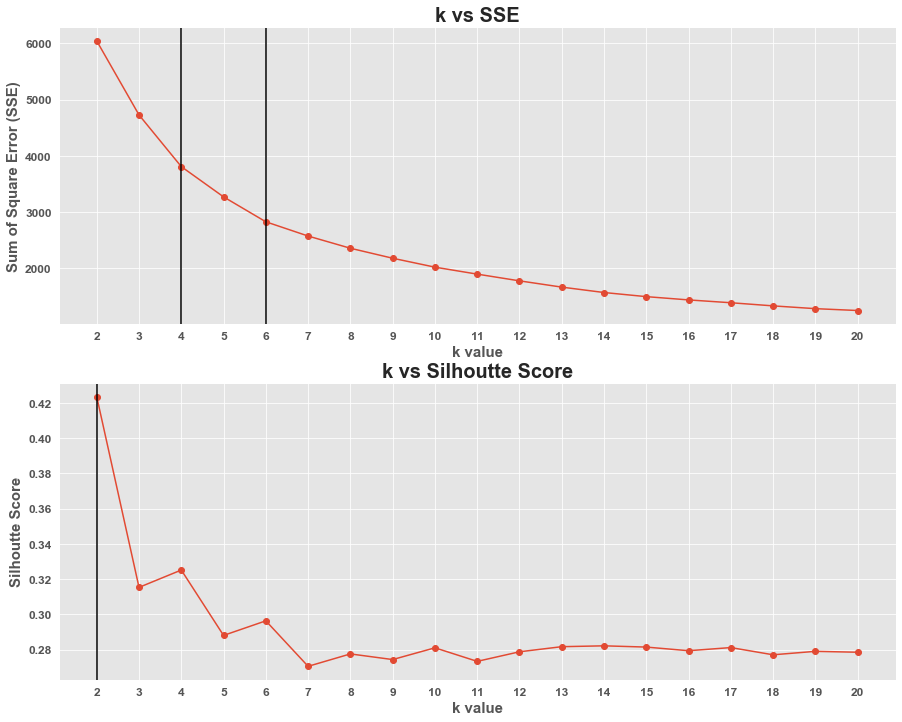

In [44]:
# choosing value of K
plt.subplots(2,1, figsize=(15,12))

# K vs SSE
plt.subplot(2,1,1)
plt.plot(list_sse, marker='o')
plt.axvline(x=2, c='black')
plt.axvline(x=4, c='black')
plt.xticks(ticks=range(0,19), labels=range(2,21), fontsize=12, fontweight='bold')
plt.xlabel("k value", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Sum of Square Error (SSE)", fontsize=15, fontweight='bold')
plt.title("k vs SSE", fontsize=20, fontweight='bold')

# K vs Silhoutte Score
plt.subplot(2,1,2)
plt.plot(list_ss, marker='o')
plt.axvline(x=0, c='black')
plt.xticks(ticks=range(0,19), labels=range(2,21), fontsize=12, fontweight='bold')
plt.xlabel("k value", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Silhoutte Score", fontsize=15, fontweight='bold')
plt.title("k vs Silhoutte Score", fontsize=20, fontweight='bold')

# display plots
plt.show()

**Observations:**

* From the Elbow plot, we can identify optimal values of K at 4 and 6 clusters.
* From the silhoutte score plot, the global minima is at K=2 clusters. Also, there are two other local minimas at K=4 and K=6 clusters.
* Keeping the business objectives in mind, and also considering the above two plots, let's choose 4 clusters as it would make sense to run 4 marketing campaigns.

In [45]:
# intializing K-Means model with K=4
cls_kmeans = KMeans(n_clusters=4)

# hyperparameters
cls_kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [46]:
# fitting on the data
cls_kmeans.fit(df_model_scaled)

# extracting the cluster labels
df_rfm['ClusterLabel'] = cls_kmeans.labels_

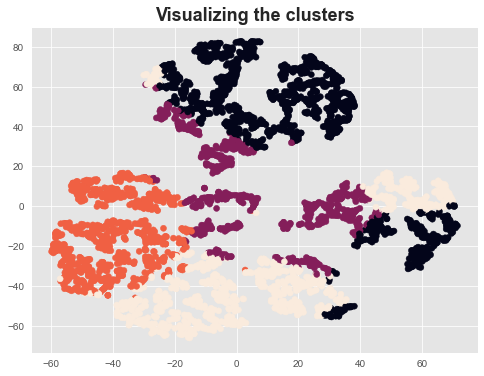

In [47]:
# visualizing the clusters (in 2D projected space)
plt.figure(figsize=(8,6))
plt.scatter(Xt[:,0], Xt[:,1], c=df_rfm['ClusterLabel'])
plt.title('Visualizing the clusters', fontsize=18, fontweight='bold')
plt.show()

**Observations:**

* Visualizing the clusters, looks like the modelling gave us fair clusters. Let's go ahead and explore what those clusters are.

## Sengmenting (Defining segments)

In [48]:
# cluster profiles
cluster_profile = df_rfm.groupby('ClusterLabel')[['Recency','Frequency','Monetary']].mean().round(2).reset_index()
cluster_profile

,ClusterLabel,Recency,Frequency,Monetary
0,0,183.70,1.30,276.80
1,1,18.34,2.13,473.70
2,2,15.86,9.53,2624.62
3,3,94.26,3.85,1181.82


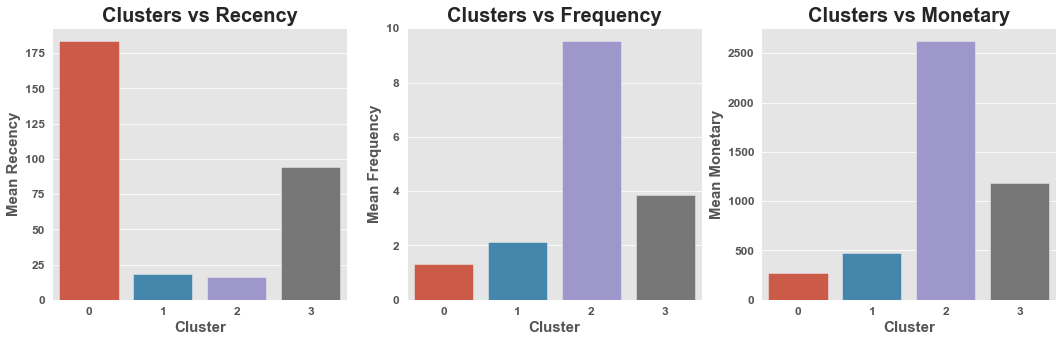

In [49]:
# comparing Recency, Frequence, Monetary
plt.subplots(1,3, figsize=(18,5))

# metrics
for i,metric in enumerate(['Recency','Frequency','Monetary'], start=1):
    plt.subplot(1,3,i)
    sns.barplot(data=cluster_profile, x='ClusterLabel', y=metric)
    plt.xticks(rotation=0, fontsize=12, fontweight='bold')
    plt.xlabel('Cluster', fontsize=15, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.ylabel("Mean "+metric, fontsize=15, fontweight='bold')
    plt.title("Clusters vs "+metric, fontsize=20, fontweight='bold')

# display plots
plt.show()

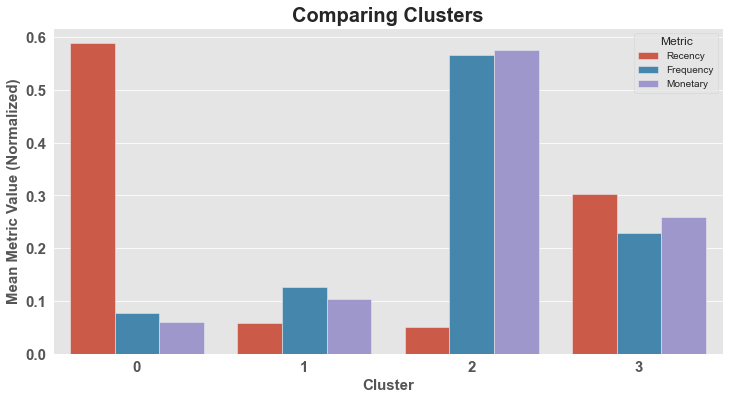

In [50]:
# normalizing and combining the metrics for side-by-side comparision
cluster_profile_normalized = cluster_profile / cluster_profile.sum()
cluster_profile_normalized['ClusterLabel'] = cluster_profile['ClusterLabel']
cluster_profile_normalized = cluster_profile_normalized.melt(id_vars='ClusterLabel', var_name='Metric', value_name='Value')

# plotting
plt.figure(figsize=(12,6))
sns.barplot(data=cluster_profile_normalized, x='ClusterLabel', y='Value', hue='Metric')
plt.xticks(fontsize=15, fontweight='bold')
plt.xlabel('Cluster', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.ylabel("Mean Metric Value (Normalized)", fontsize=15, fontweight='bold')
plt.title("Comparing Clusters", fontsize=20, fontweight='bold')
plt.show()

**Observations:**

1. **Cluster label: 0**
    * Least recent
    * Least frequent
    * Least monetary
    * Segment name: `Hibernating`


2. **Cluster label: 1**
    * Recent shoppers
    * Bought more than once, but not often
    * Haven't spent much
    * Segment name: `New Customers - Promising`
    

3. **Cluster label: 2**
    * Most recent
    * Highest frequency
    * Highest monetary
    * Segment name: `Champions`
    

4. **Cluster label: 3**
    * Below average recency
    * Above average frequency
    * Above average monetary
    * Segment name: `At Risk - Need Attention`

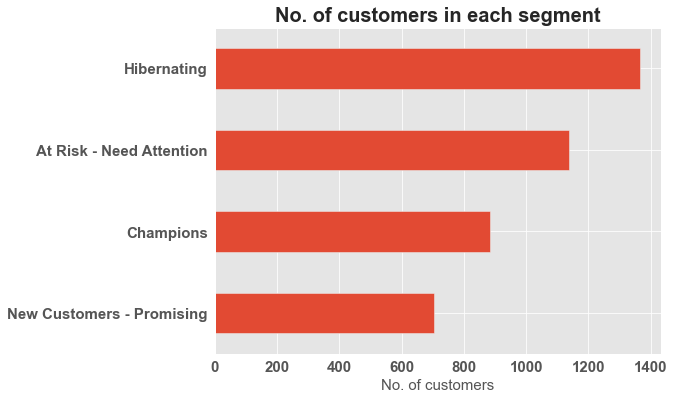

In [52]:
# assigning customers to their identified and defined segments
df_rfm['CustomerSegment'] = df_rfm['ClusterLabel'].apply(lambda x: "Hibernating" if x == 0
                                                                     else ("New Customers - Promising" if x == 1 
                                                                           else ("Champions" if x == 2 else "At Risk - Need Attention")))

# visualizing the no. of customer in each segment
plt.figure(figsize=(8,6))
df_rfm.groupby('CustomerSegment')['CustomerID'].count().sort_values().plot(kind='barh', ax=plt.gca())
plt.xticks(fontsize=15, fontweight='bold')
plt.xlabel('No. of customers', fontsize=15)
plt.yticks(fontsize=15, fontweight='bold')
plt.ylabel('')
plt.title('No. of customers in each segment', fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* Looks like the online retailer is not doing good, majority of the customers are either `Hibernating` or `At Risk - Need Attention`.
* Well, the company had approached us at the right time, because now with identifying each customer and their segment, the retailer can run promotions and offers more accurately and in a tailored manner, hence improve the customer engagement and sales.